# Population estimation

## 1. The challenge: Helmholtz AI CountMeIn

## 2. The data
**Population data**: The European Statistical System (ESSnet) project, in co-operation with the European Forum for Geography and Statistics (EFGS), produced the high resolution (1km) population grids from the population census in Europe. We processed this freely available population grids for each city. 

**Sentinel-2 (SEN2)**: Processed only the RGB bands at 10 m resolution for all four seasonal sets (spring, summer, autumn and winter) of Sentinel-2 images to capture the seasonal variation in the data.

**Local climate zones (LCZ)**: Processed the urban local climate zone classifications, So2Sat LCZ v1.0, produced by fusing the freely available satellite data from Sentinel-1 and Sentinel-2 satellites using deep learning.

**Nighttime lights (VIIRS)**: Processed the freely available cloud free annual composites of global VIIRS nighttime lights.

**Land use classification (LU)**: Mapped OSM tags to a simplified land use classification scheme: commercial, industrial, residential, and other that results in a four band raster with corresponding land use proportions.

In [ ]:
# install the required packages
import sys
!{sys.executable} -m pip install -r requirements.txt

In [102]:
import h5py
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# this should match the name of the data sets
filename_train = 'data/train_countmein.h5'
filename_test = 'data/test_countmein.h5'

dataset_train = h5py.File(filename_train, 'r')
dataset_test = h5py.File(filename_test, 'r')

# show the content names
print(list(dataset_train.keys()))

['lcz', 'lu', 'population', 'sentinel2_autumn', 'sentinel2_spring', 'sentinel2_summer', 'sentinel2_winter', 'viirs']


In [4]:
pop_train = np.array(dataset_train['population'])

# show the shape
print("Population train data shape: ", pop_train.shape)

# print the ground truth for one sample
print("This is how the ground truth for one sample looks like:", pop_train[100,:])

# note that it is a pair (class, population count), thus we store just one part
pop_count_train = pop_train[:,1]

pop_test = np.array(dataset_test['population'])
pop_count_test = pop_test[:,1]

Population train data shape:  (267, 2)
This is how the ground truth for one sample looks like: [ 7 99]


Sentinel-2 shape:  (267, 100, 100, 3)


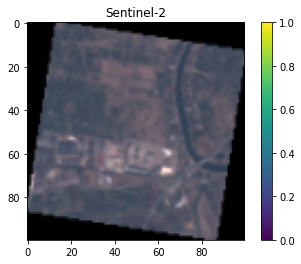

In [92]:
# load Sentinel-2 data (Spring snapshots)
sen2_spring_train = np.array(dataset_train['sentinel2_spring'])
sen2_spring_test = np.array(dataset_test['sentinel2_spring'])

print("Sentinel-2 shape: ", sen2_spring_train.shape)
# 267, 100x100 pixels, 3 channels samples

def norm_img(X):        
    return ((X - np.min(X)) / (np.max(X) - np.min(X)))
    

index = 119

plt.imshow(norm_img(sen2_spring_train[index,:]))
plt.colorbar()
plt.title('Sentinel-2')
plt.show()

VIIRS shape:  (267, 100, 100, 1)


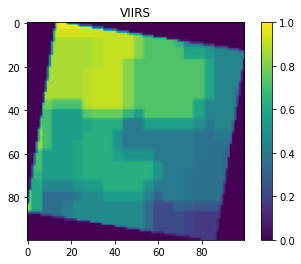

In [93]:
# load VIIRS
viirs_train = np.array(dataset_train['viirs'])

print("VIIRS shape: ", viirs_train.shape)
# 267, 100x100 pixels, 3 channels samples

def norm_img(X):        
    return ((X - np.min(X)) / (np.max(X) - np.min(X)))
    

plt.imshow(norm_img(viirs_train[index,:]))
plt.colorbar()
plt.title('VIIRS')
plt.show()

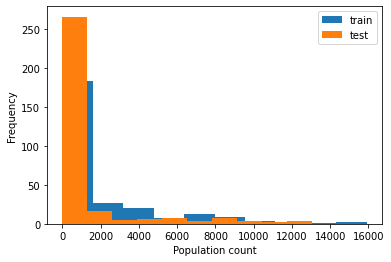

In [94]:
plt.hist(pop_count_train, label="train")
plt.hist(pop_count_test, label="test")
plt.xlabel("Population count")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.show()

## 3. Random forest regressor


In [135]:
# Random forest regressor needs a vector as input
_shape = sen2_spring_train.shape
X_train = np.reshape(sen2_spring_train, (_shape[0], _shape[1] * _shape[2] * _shape[3]))
print("X train shape:", X_train.shape)

n_test = sen2_spring_test.shape[0]
X_test = np.reshape(sen2_spring_test, (n_test, _shape[1] * _shape[2] * _shape[3]))
print("X test shape:", X_test.shape)

X train shape: (267, 30000)
X test shape: (324, 30000)


In [8]:
rf_base = RandomForestRegressor(random_state=3108)

rf_base.fit(X_train, pop_count_train)

RandomForestRegressor(random_state=3108)

In [10]:
pop_pred_rf = rf_base.predict(X_test)

In [11]:
mae_base = mean_absolute_error(pop_count_test, pop_pred_rf)
rmse_base = mean_squared_error(pop_count_test, pop_pred_rf, squared=False) # squared=True -> MSE, squared=False -> RMSE
r2_base = r2_score(pop_count_test, pop_pred_rf)

print("MAE:", mae_base) # Best possible is 0
print("RMSE:", rmse_base) # Best possible is 0
print("R2:", r2_base) # Best possible is 1

MAE: 2855.3273148148146
RMSE: 3273.3599399767745
R2: -0.6254334813250992


Total population in test set: 379191
Total population predicted: 935716
Average population per sample in test set: 1170.3425925925926
Average population per sample in predicted set: 2888.0149691358024


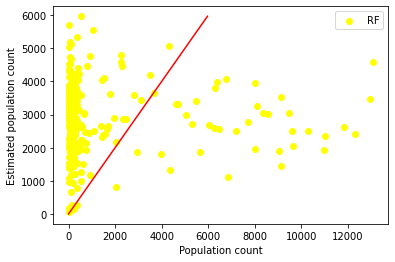

In [148]:
print("Total population in test set:", np.sum(pop_count_test))
print("Total population predicted:", int(np.sum(pop_pred_rf)))

print("Average population per sample in test set:", np.average(pop_count_test))
print("Average population per sample in predicted set:", np.average(pop_pred_rf))

lim = int(np.min( [np.max(pop_count_test), np.max(pop_pred_rf)]))

plt.scatter(pop_count_test, pop_pred_rf, label="RF", color="yellow")
plt.legend(loc="upper right")
plt.xlabel("Population count")
plt.ylabel("Estimated population count")
plt.plot( [0, lim], [0, lim], color="red")
plt.show()

## 4. Artificial neural network

In [38]:
simple_nn = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(_shape[1], _shape[2], _shape[3])),
  tf.keras.layers.Dense(128, activation='relu'),  
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1),
])

simple_nn.compile(optimizer='adam',
              loss='mean_absolute_error')

In [41]:
simple_nn.fit(sen2_spring_train, pop_count_train, epochs=5)

Epoch 1/5
9/9 [==============================] - 0s 14ms/step - loss: 2988.7996
Epoch 2/5
9/9 [==============================] - 0s 14ms/step - loss: 3203.2195
Epoch 3/5
9/9 [==============================] - 0s 14ms/step - loss: 4532.0449
Epoch 4/5
9/9 [==============================] - 0s 14ms/step - loss: 4317.0601
Epoch 5/5
9/9 [==============================] - 0s 14ms/step - loss: 4297.1533


In [42]:
pop_pred_nn = simple_nn.predict(sen2_spring_test)

In [43]:
mae_nn = mean_absolute_error(pop_count_test, pop_pred_nn)
rmse_nn = mean_squared_error(pop_count_test, pop_pred_nn, squared=False) # squared=True -> MSE, squared=False -> RMSE
r2_nn = r2_score(pop_count_test, pop_pred_nn)

print("MAE:", mae_nn) # Best possible is 0
print("RMSE:", rmse_nn) # Best possible is 0
print("R2:", r2_nn) # Best possible is 1

MAE: 6663.108746563947
RMSE: 6927.027051250452
R2: -6.279062398189521


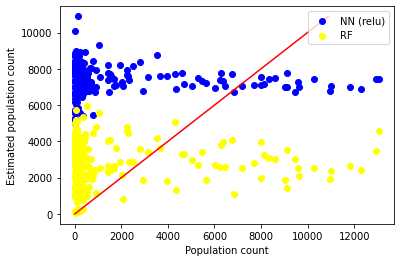

In [147]:
lim = int(np.min( [np.max(pop_count_test), np.max(pop_pred_nn)]))

plt.scatter(pop_count_test, pop_pred_nn, label="NN (relu)", color="blue")
plt.scatter(pop_count_test, pop_pred_rf, label="RF", color="yellow")
plt.legend(loc="upper right")
plt.xlabel("Population count")
plt.ylabel("Estimated population count")
plt.plot( [0, lim], [0, lim], color="red")
plt.show()

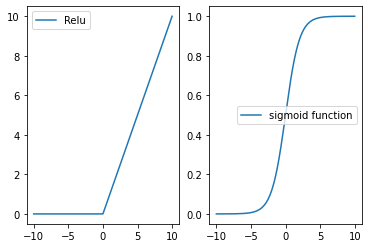

In [99]:
x = np.linspace(-10, 10, 1000)
y_sigmoid = 1 / (1 + np.exp(-x) )
y_relu = np.maximum(0, x)

plt.subplot(1,2,1)
plt.plot(x, y_relu)
plt.legend(['Relu'])

plt.subplot(1,2,2)
plt.plot(x, y_sigmoid)
plt.legend(['sigmoid function'])
plt.show()

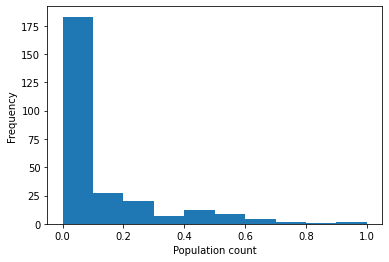

In [101]:
pop_scaler = MinMaxScaler() 
pop_scaler.fit(pop_count_train.reshape(-1,1))
scaled_pop_count_train = pop_scaler.transform(pop_count_train.reshape(-1,1))

plt.hist(scaled_pop_count_train, label="train")
plt.xlabel("Population count")
plt.ylabel("Frequency")
plt.show()

In [82]:
simple_nn_v2 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(_shape[1], _shape[2], _shape[3])),
  tf.keras.layers.Dense(128, activation='sigmoid'),  
  tf.keras.layers.Dense(64, activation='sigmoid'),
  tf.keras.layers.Dense(1, activation="sigmoid"),
])

simple_nn_v2.compile(optimizer='adam',
              loss='mean_absolute_error')

simple_nn_v2.fit(sen2_spring_train, scaled_pop_count_train, epochs=5)

pop_pred_nn_scaled_v2 = simple_nn_v2.predict(sen2_spring_test)
pop_pred_nn_v2 = pop_scaler.inverse_transform(pop_pred_nn_scaled_v2)

mae_nn_v2 = mean_absolute_error(pop_count_test, pop_pred_nn_v2)
rmse_nn_v2 = mean_squared_error(pop_count_test, pop_pred_nn_v2, squared=False) # squared=True -> MSE, squared=False -> RMSE
r2_nn_v2 = r2_score(pop_count_test, pop_pred_nn_v2)

print("MAE:", mae_nn_v2) # Best possible is 0
print("RMSE:", rmse_nn_v2) # Best possible is 0
print("R2:", r2_nn_v2) # Best possible is 1

Epoch 1/5
9/9 [==============================] - 0s 15ms/step - loss: 0.1179
Epoch 2/5
9/9 [==============================] - 0s 15ms/step - loss: 0.1144
Epoch 3/5
9/9 [==============================] - 0s 14ms/step - loss: 0.1150
Epoch 4/5
9/9 [==============================] - 0s 13ms/step - loss: 0.1148
Epoch 5/5
9/9 [==============================] - 0s 13ms/step - loss: 0.1145
MAE: 1161.9170633009921
RMSE: 2683.892817460918
R2: -0.09272784811702794


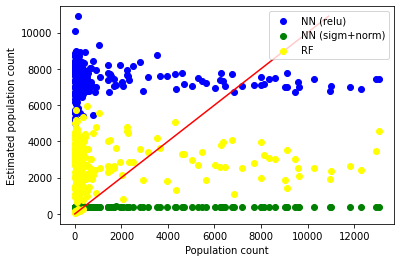

In [146]:
plt.scatter(pop_count_test, pop_pred_nn, label="NN (relu)", color="blue")
plt.scatter(pop_count_test, pop_pred_nn_v2, label="NN (sigm+norm)", color="green")

plt.scatter(pop_count_test, pop_pred_rf, label="RF", color="yellow")
plt.legend(loc="upper right")
plt.xlabel("Population count")
plt.ylabel("Estimated population count")
plt.plot( [0, lim], [0, lim], color="red")
plt.show()

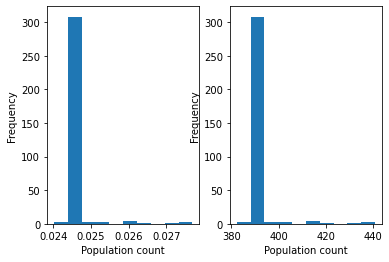

In [89]:
plt.subplot(1,2,1)
plt.hist(pop_pred_nn_scaled_v2)
plt.xlabel("Population count scaled")
plt.ylabel("Frequency")


plt.subplot(1,2,2)
plt.hist(pop_pred_nn_v2)
plt.xlabel("Population count")
plt.ylabel("Frequency")
plt.show()


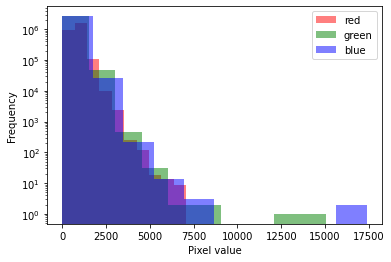

In [130]:
plt.hist(sen2_spring_train[:,:,:,0].flatten(), label="red", color="red", alpha=0.5)
plt.hist(sen2_spring_train[:,:,:,1].flatten(), label="green", color="green", alpha=0.5)
plt.hist(sen2_spring_train[:,:,:,2].flatten(), label="blue", color="blue", alpha=0.5)
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.yscale("log")
plt.show()

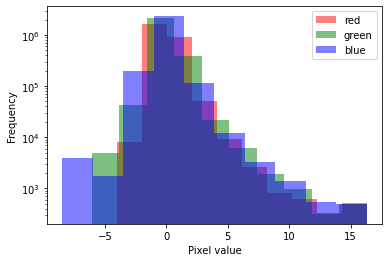

In [136]:
s2_scaler = StandardScaler()
s2_scaler.fit(sen2_spring_train.reshape((_shape[0], _shape[1] * _shape[2] * _shape[3])))
sen2_spring_train_stdized = s2_scaler.transform(
    sen2_spring_train.reshape((_shape[0], _shape[1] * _shape[2] * _shape[3])))
sen2_spring_train_stdized = sen2_spring_train_stdized.reshape((_shape[0], _shape[1], _shape[2], _shape[3]))

plt.hist(sen2_spring_train_stdized[:,:,:,0].flatten(), label="red", color="red", alpha=0.5)
plt.hist(sen2_spring_train_stdized[:,:,:,1].flatten(), label="green", color="green", alpha=0.5)
plt.hist(sen2_spring_train_stdized[:,:,:,2].flatten(), label="blue", color="blue", alpha=0.5)
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.yscale("log")
plt.show()

Epoch 1/5
9/9 [==============================] - 0s 13ms/step - loss: 0.4768
Epoch 2/5
9/9 [==============================] - 0s 14ms/step - loss: 0.2768
Epoch 3/5
9/9 [==============================] - 0s 14ms/step - loss: 0.1541
Epoch 4/5
9/9 [==============================] - 0s 13ms/step - loss: 0.1214
Epoch 5/5
9/9 [==============================] - 0s 13ms/step - loss: 0.1133
MAE: 1357.4596445531022
RMSE: 2584.0253530263903
R2: -0.012920162107409983


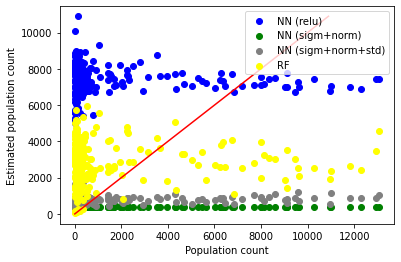

In [145]:
simple_nn_v3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(_shape[1], _shape[2], _shape[3])),
  tf.keras.layers.Dense(128, activation='sigmoid'),  
  tf.keras.layers.Dense(64, activation='sigmoid'),
  tf.keras.layers.Dense(1, activation="sigmoid"),
])

simple_nn_v3.compile(optimizer='adam',
              loss='mean_absolute_error')

simple_nn_v3.fit(sen2_spring_train_stdized, scaled_pop_count_train, epochs=5)

sen2_spring_test_stdized = s2_scaler.transform(
    sen2_spring_test.reshape((n_test, _shape[1] * _shape[2] * _shape[3])))
sen2_spring_test_stdized = sen2_spring_test_stdized.reshape((n_test, _shape[1], _shape[2], _shape[3]))

pop_pred_nn_scaled_v3 = simple_nn_v3.predict(sen2_spring_test_stdized)
pop_pred_nn_v3 = pop_scaler.inverse_transform(pop_pred_nn_scaled_v3)

mae_nn_v3 = mean_absolute_error(pop_count_test, pop_pred_nn_v3)
rmse_nn_v3 = mean_squared_error(pop_count_test, pop_pred_nn_v3, squared=False) # squared=True -> MSE, squared=False -> RMSE
r2_nn_v3 = r2_score(pop_count_test, pop_pred_nn_v3)

print("MAE:", mae_nn_v3) # Best possible is 0
print("RMSE:", rmse_nn_v3) # Best possible is 0
print("R2:", r2_nn_v3) # Best possible is 1

plt.scatter(pop_count_test, pop_pred_nn, label="NN (relu)", color="blue")
plt.scatter(pop_count_test, pop_pred_nn_v2, label="NN (sigm+norm)", color="green")
plt.scatter(pop_count_test, pop_pred_nn_v3, label="NN (sigm+norm+std)", color="gray")
plt.scatter(pop_count_test, pop_pred_rf, label="RF", color="yellow")
plt.legend(loc="upper right")
plt.xlabel("Population count")
plt.ylabel("Estimated population count")
plt.plot( [0, lim], [0, lim], color="red")
plt.show()

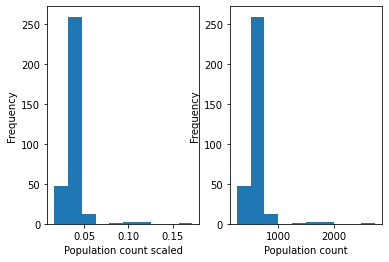

In [141]:
plt.subplot(1,2,1)
plt.hist(pop_pred_nn_scaled_v3)
plt.xlabel("Population count scaled")
plt.ylabel("Frequency")


plt.subplot(1,2,2)
plt.hist(pop_pred_nn_v3)
plt.xlabel("Population count")
plt.ylabel("Frequency")
plt.show()


## 5. Data fusion

### 5.1. Input level